In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime, timedelta
import networkx as nx
from tqdm import tqdm
import seaborn as sns

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)
sns.set_theme()

In [2]:
years = 8
date_to = "10.06.2023"

imoex_shares_path = "../data/tickers_info/imoex_shares.csv"
imoex_index_shares_path = "../data/tickers_info/imoex_index_shares.csv"
daily_data_folder = f"../data/historical/daily_data_for_{years}_years_till_{datetime.strptime(date_to, '%d.%m.%Y').strftime('%Y-%m-%d')}/"

def daily_data_fname(ticker, uid):
    return f"{ticker}_{uid}.csv"

In [3]:
shares_info = pd.read_csv(imoex_shares_path) # interchangable with imoex_index_shares_path
print(shares_info.shape)
shares_info.head(5)

(139, 4)


,figi,ticker,name,uid
0,BBG000BN56Q9,DSKY,Детский Мир,6e061639-6198-4448-9568-1eadb1b0e127
1,BBG000RMWQD4,ENPG,En+ Group,e2bd2eba-75de-4127-b39c-2f2dbe3866c3
2,BBG004PYF2N3,POLY,Polymetal,127361c2-32ec-448c-b3ec-602166f537ea
3,BBG000GQSVC2,NKNCP,Нижнекамскнефтехим - акции привилегированные,bc21fb4f-8838-4355-8697-fb0d8fc809c8
4,BBG000FWGSZ5,IRKT,Корпорация ИРКУТ,cfb50a23-2465-497e-bc7e-e4f0e042cf3d


In [64]:
np.corrcoef([1,2,3], [0, 0, -1])

array([[ 1.   , -0.866],
       [-0.866,  1.   ]])

In [38]:
# Count share returns

# "fill" - fill with 0
# "cut"  - cut to maximum start date
act_w_missing_starts = "fill"

# If the stock started trading after this date - remove it
max_first_date_to_exist = datetime.strptime(date_to, '%d.%m.%Y') - timedelta(days=365 * years - 50)

common_df, date_start = None, None
for idx, info in shares_info.iterrows():
    cur_df = pd.read_csv(daily_data_folder + daily_data_fname(info["ticker"], info["uid"]), index_col=0)
    cur_df.index = pd.to_datetime(cur_df.index)
    # From the book
    cur_df = pd.DataFrame(np.log(cur_df["close"] / cur_df["open"]), columns=[info["ticker"]])
    # Diff percentage
    # cur_df = pd.DataFrame((cur_df["close"] - cur_df["open"]) / cur_df["open"], columns=[info["ticker"]])
    cur_min_date = cur_df.index.min()
    print(f"{info['name']}\t first candle date is: {cur_min_date}")
    if max_first_date_to_exist is not None and cur_min_date > max_first_date_to_exist:
        print(f"Stock {info['ticker']} started trading too late for research")
        continue
    if common_df is None:
        common_df = cur_df
        date_start = cur_min_date
    else:
        common_df = common_df.join(cur_df, how="outer")
        if date_start < cur_min_date:
            date_start = cur_min_date
if act_w_missing_starts == "fill":
    print(f"Min date is: {common_df.index.min()}")
elif act_w_missing_starts == "cut":
    common_df = common_df.loc[common_df.index >= date_start]
    print(f"Min date is: {date_start}")
else:
    raise RuntimeError("Unknown missing starts action")
common_df = common_df.fillna(0).sort_index().copy()
common_df

Детский Мир	 first candle date is: 2017-02-10 00:00:00
Stock DSKY started trading too late for research
En+ Group	 first candle date is: 2020-02-20 00:00:00
Stock ENPG started trading too late for research
Polymetal	 first candle date is: 2015-06-12 00:00:00
Нижнекамскнефтехим - акции привилегированные	 first candle date is: 2015-06-15 00:00:00
Корпорация ИРКУТ	 first candle date is: 2015-06-15 00:00:00
МРСК Волги	 first candle date is: 2015-06-15 00:00:00
ВСМПО-АВИСМА	 first candle date is: 2015-06-15 00:00:00
Объединенная авиастроительная корпорация	 first candle date is: 2015-06-15 00:00:00
Группа ЛСР	 first candle date is: 2015-06-15 00:00:00
Таттелеком	 first candle date is: 2015-06-15 00:00:00
Центральный Телеграф	 first candle date is: 2015-06-15 00:00:00
Магнит	 first candle date is: 2015-06-12 00:00:00
СОЛЛЕРС	 first candle date is: 2015-06-15 00:00:00
Etalon Group PLC ГДР	 first candle date is: 2020-02-03 00:00:00
Stock ETLN started trading too late for research
Ростелеком - 

,POLY,NKNCP,IRKT,MRKV,VSMO,UNAC,LSRG,TTLK,CNTL,MGNT,...,AMEZ,TGKBP,PIKK,ROSN,MTLRP,TRMK,MRKU,MRKY,KRKNP,CHMF
2015-06-12,0.0165,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090,...,0.0000,0.0000,-0.0331,-0.0029,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0165
2015-06-15,0.0151,0.0211,0.0226,0.0091,0.0146,0.0055,0.0033,-0.0130,0.0411,0.0112,...,-0.0078,0.1051,0.0261,-0.0074,0.0193,0.0094,0.0622,-0.0121,0.0000,0.0151
2015-06-16,-0.0151,-0.0206,-0.0015,-0.0636,-0.0033,0.0255,-0.0081,0.0000,0.0458,0.0277,...,-0.0098,0.0000,0.0232,0.0100,-0.0142,0.0037,0.0124,0.0359,0.0037,-0.0082
2015-06-17,0.0098,-0.0105,0.0337,-0.0647,0.0022,0.0143,-0.0016,-0.0087,0.0000,0.0017,...,0.0000,0.0645,-0.0214,0.0008,-0.0071,-0.0130,0.0061,-0.0242,0.0000,-0.0167
2015-06-18,0.0211,0.0123,-0.0160,-0.0139,0.0011,0.0265,-0.0130,-0.0043,0.0317,-0.0009,...,0.1438,-0.0315,-0.0553,-0.0026,0.0263,0.0185,-0.0098,-0.0090,0.0000,-0.0120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,-0.0052,-0.0087,-0.0110,-0.0049,-0.0094,-0.0106,0.0146,-0.0162,-0.0175,0.0056,...,-0.0219,-0.0200,0.0025,0.0103,0.0456,0.0347,0.0133,-0.0041,-0.0093,-0.0078
2023-06-07,-0.0058,0.0073,-0.0034,0.0122,-0.0045,0.0029,-0.0008,0.0105,-0.0054,0.0002,...,0.0160,0.0109,-0.0048,-0.0050,0.0142,-0.0068,-0.0119,0.0051,0.0093,-0.0023
2023-06-08,-0.0101,0.0367,0.0017,-0.0134,0.0012,-0.0093,-0.0088,-0.0077,0.0027,0.0047,...,-0.0173,-0.0099,0.0101,-0.0040,-0.0050,0.0038,-0.0208,-0.0041,-0.0077,0.0196
2023-06-09,-0.0522,-0.0123,-0.0042,-0.0147,0.0033,0.0093,0.0124,-0.0146,-0.0081,-0.0038,...,0.0048,-0.0018,-0.0074,0.0098,-0.0069,-0.0141,-0.0102,-0.0274,-0.0015,-0.0118


In [39]:
# Number of days missing

(common_df.head(500) == 0).sum().sort_values(ascending=False).head(50)

VTBR     465
FEES     382
NSVZ     311
TGKN     294
TGKBP    273
KLSB     213
PMSB     209
UNKL     192
KRKNP    185
HYDR     174
KROT     172
CNTL     153
ROLO     150
PRFN     140
RKKE     133
CBOM     129
MGTSP    125
TTLK     122
KZOSP    110
KZOS     102
DVEC      81
RUGR      80
PMSBP     77
MRKS      72
IRAO      62
LSNGP     59
AMEZ      58
LNZL      57
MSRS      57
QIWI      56
MRKZ      56
FESH      54
AGRO      53
LNZLP     53
NKNC      51
RTKMP     50
BLNG      50
SVAV      49
MRKU      48
TGKB      48
KMAZ      46
SELG      45
MRKY      44
APTK      42
MRKC      42
BSPB      41
VSMO      39
NKNCP     39
ELFV      37
IRKT      35
dtype: int64

In [40]:
filter_stocks = []

for col in common_df.columns:
    if col.endswith("P") and col[:-1] in common_df.columns:
        filter_stocks.append(col)

common_df = common_df.loc[:,~common_df.columns.isin(filter_stocks)].copy()
common_df

,POLY,IRKT,MRKV,VSMO,UNAC,LSRG,TTLK,CNTL,MGNT,SVAV,...,SNGS,CBOM,AMEZ,PIKK,ROSN,TRMK,MRKU,MRKY,KRKNP,CHMF
2015-06-12,0.0165,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090,0.0000,...,0.0003,0.0000,0.0000,-0.0331,-0.0029,0.0000,0.0000,0.0000,0.0000,-0.0165
2015-06-15,0.0151,0.0226,0.0091,0.0146,0.0055,0.0033,-0.0130,0.0411,0.0112,0.0047,...,0.0243,0.0000,-0.0078,0.0261,-0.0074,0.0094,0.0622,-0.0121,0.0000,0.0151
2015-06-16,-0.0151,-0.0015,-0.0636,-0.0033,0.0255,-0.0081,0.0000,0.0458,0.0277,0.0161,...,0.0294,0.0000,-0.0098,0.0232,0.0100,0.0037,0.0124,0.0359,0.0037,-0.0082
2015-06-17,0.0098,0.0337,-0.0647,0.0022,0.0143,-0.0016,-0.0087,0.0000,0.0017,0.0092,...,-0.0081,0.0000,0.0000,-0.0214,0.0008,-0.0130,0.0061,-0.0242,0.0000,-0.0167
2015-06-18,0.0211,-0.0160,-0.0139,0.0011,0.0265,-0.0130,-0.0043,0.0317,-0.0009,-0.0205,...,-0.0090,0.0000,0.1438,-0.0553,-0.0026,0.0185,-0.0098,-0.0090,0.0000,-0.0120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,-0.0052,-0.0110,-0.0049,-0.0094,-0.0106,0.0146,-0.0162,-0.0175,0.0056,0.0215,...,0.0106,0.0007,-0.0219,0.0025,0.0103,0.0347,0.0133,-0.0041,-0.0093,-0.0078
2023-06-07,-0.0058,-0.0034,0.0122,-0.0045,0.0029,-0.0008,0.0105,-0.0054,0.0002,0.0266,...,-0.0016,0.0000,0.0160,-0.0048,-0.0050,-0.0068,-0.0119,0.0051,0.0093,-0.0023
2023-06-08,-0.0101,0.0017,-0.0134,0.0012,-0.0093,-0.0088,-0.0077,0.0027,0.0047,-0.0325,...,0.0127,0.0116,-0.0173,0.0101,-0.0040,0.0038,-0.0208,-0.0041,-0.0077,0.0196
2023-06-09,-0.0522,-0.0042,-0.0147,0.0033,0.0093,0.0124,-0.0146,-0.0081,-0.0038,-0.0211,...,-0.0150,-0.0050,0.0048,-0.0074,0.0098,-0.0141,-0.0102,-0.0274,-0.0015,-0.0118


In [72]:
common_df.columns.values

array(['POLY', 'IRKT', 'MRKV', 'VSMO', 'UNAC', 'LSRG', 'TTLK', 'CNTL',
       'MGNT', 'SVAV', 'KMAZ', 'KZOS', 'PHOR', 'LNZL', 'MGTSP', 'ELFV',
       'SELG', 'AGRO', 'BLNG', 'MAGN', 'VTBR', 'BANE', 'AFLT', 'RUAL',
       'SBER', 'MVID', 'ALRS', 'MRKP', 'TATN', 'MTLR', 'AKRN', 'GAZP',
       'DVEC', 'RTKM', 'BSPB', 'MTSS', 'TGKN', 'TRNFP', 'RKKE', 'LSNG',
       'MRKC', 'FEES', 'KROT', 'RUGR', 'PMSB', 'PRFN', 'SIBN', 'TGKB',
       'KLSB', 'CHMK', 'MSRS', 'MRKZ', 'APTK', 'QIWI', 'IRAO', 'HYDR',
       'NSVZ', 'NLMK', 'GCHE', 'YNDX', 'FESH', 'RASP', 'NVTK', 'UNKL',
       'NKNC', 'GMKN', 'MOEX', 'UPRO', 'MRKS', 'ROLO', 'MSNG', 'AFKS',
       'PLZL', 'LKOH', 'OGKB', 'NMTP', 'TGKA', 'SNGS', 'CBOM', 'AMEZ',
       'PIKK', 'ROSN', 'TRMK', 'MRKU', 'MRKY', 'KRKNP', 'CHMF'],
      dtype=object)

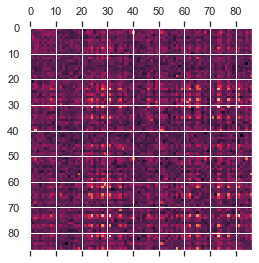

In [41]:
common_edges = common_df.head(500).corr(method="pearson").values
np.fill_diagonal(common_edges, 0)
plt.matshow(common_edges)

In [42]:
date_min = common_df.index.min()
date_max = common_df.index.max()
print(f"We have data from {date_min.date()} to {date_max.date()} inclusive")

We have data from 2015-06-12 to 2023-06-10 inclusive


In [69]:
# Choosing periods for market graphs. Let's take it monthly, yearly and overall. First inclusive, second exclusive

periods = []

# # Overall period
# periods.append((date_min, date_max + timedelta(days=1)))

# 500 traded-days peroids, 50-days shift
period = 500
shift = 50
cur_idx = 0
while common_df[cur_idx: cur_idx + period].shape[0] == period:
    periods.append((common_df.index[cur_idx], common_df.index[cur_idx + period]))
    cur_idx += shift
periods = periods[:32]

# # Yearly periods
# period = timedelta(days=365)
# d_start_tmp = date_min
# while d_start_tmp + period < date_max:
#     periods.append((d_start_tmp, d_start_tmp + period))
#     d_start_tmp += period
# if d_start_tmp + period - date_max < timedelta(days=10):
#     periods.append((d_start_tmp, date_max + timedelta(days=1)))

# # Monthly periods
# period = timedelta(days=30)
# d_start_tmp = date_min
# while d_start_tmp + period < date_max:
#     periods.append((d_start_tmp, d_start_tmp + period))
#     d_start_tmp += period
# if d_start_tmp + period - date_max < timedelta(days=10):
#     periods.append((d_start_tmp, date_max + timedelta(days=1)))

periods_print = pd.DataFrame({"Period start": [period[0] for period in periods],
                              "Period end": [period[1] for period in periods]},
                             index=np.arange(1, len(periods) + 1))
periods_print.head(16)

,Period start,Period end
1,2015-06-12,2017-05-11
2,2015-08-21,2017-07-20
3,2015-10-30,2017-09-28
4,2016-01-08,2017-12-07
5,2016-03-17,2018-02-15
6,2016-05-26,2018-04-19
7,2016-08-04,2018-06-18
8,2016-10-13,2018-08-27
9,2016-12-22,2018-11-06
10,2017-03-02,2019-01-18


In [70]:
periods_print.tail(16)

,Period start,Period end
17,2018-06-18,2020-06-10
18,2018-08-27,2020-08-24
19,2018-11-06,2020-11-02
20,2019-01-18,2021-01-15
21,2019-04-01,2021-03-29
22,2019-06-13,2021-06-08
23,2019-08-22,2021-08-17
24,2019-10-31,2021-10-26
25,2020-01-16,2022-01-06
26,2020-03-30,2022-04-14


In [109]:
# Build threshold graphs + find max cliques

thresholds_range = [("pearson", 0.1*i) for i in range(10)] + [("kendall", 0.05*i) for i in range(13)]

data = []
pbar = tqdm(total=len(periods) * len(thresholds_range))
for period in periods:
    # Calculating Kendall correlation
    sub_df = common_df.loc[(period[0] <= common_df.index) & (common_df.index < period[1])]
    vertices = sub_df.columns
    edges_p = np.abs(sub_df.corr(method="pearson"))
    edges_k = sub_df.corr(method="kendall")
    np.fill_diagonal(edges_p.values, 0)
    np.fill_diagonal(edges_k.values, 0)
    data.append((period, {}))

    for method, threshold in thresholds_range:
        if method == "pearson":
            edges = edges_p
        elif method == "kendall":
            edges = edges_k
        else:
            raise RuntimeError("Unknown correlation method")
        cur_data_name = f"{method}_{threshold:.2f}"
        data[-1][1][cur_data_name] = {}

        # Building a threshold market graph
        G = nx.Graph()
        G.add_nodes_from(vertices)
        for i in range(edges.shape[0]):
            for j in range(i+1, edges.shape[0]):
                if edges.values[i, j] > threshold:
                    G.add_edge(vertices[i], vertices[j])
        data[-1][1][cur_data_name]["graph"] = G
        
        # Finding maximum cliques
        max_cliques_arr = []
        max_cliques_size = 0
        for clique in nx.clique.find_cliques(G):
            if len(clique) > max_cliques_size:
                max_cliques_size = len(clique)
                max_cliques_arr = [sorted(clique)]
            elif len(clique) == max_cliques_size:
                max_cliques_arr.append(sorted(clique))
        data[-1][1][cur_data_name]["max_clique_size"] = max_cliques_size
        data[-1][1][cur_data_name]["max_cliques_number"] = len(max_cliques_arr)

        # Union of max cliques w/ contribution
        shares_appearance_perc = {}
        one_stock_contrib = max_cliques_size * len(max_cliques_arr)
        for max_cl in max_cliques_arr:
            for share in max_cl:
                if share in shares_appearance_perc:
                    shares_appearance_perc[share] += 1 / one_stock_contrib
                else:
                    shares_appearance_perc[share] = 1 / one_stock_contrib
        data[-1][1][cur_data_name]["shares_appearance_perc"] = shares_appearance_perc
        pbar.update(1)

 99%|█████████▉| 729/736 [00:58<00:00, 18.94it/s]

In [196]:
len([[1,2], [3,4]])

2

In [110]:
def plot_area_chart(data, data_name, contrib_threshold=0.1):
    common_df = None
    for period, info in data:
        cur_df = pd.DataFrame.from_dict(info[data_name]["shares_appearance_perc"], orient="index", columns=[period[0]])
        if common_df is None:
            common_df = cur_df
        else:
            common_df = common_df.join(cur_df, how="outer")
    common_df = common_df.fillna(0).sort_index()

    # Sum small values and drop empty columns
    other_sum = common_df[common_df < contrib_threshold].sum().rename("Smaller contribs")
    common_df[common_df < contrib_threshold] = 0
    common_df = common_df.append(other_sum)
    common_df = common_df.loc[(common_df > 0).any(axis=1)].copy()

    # Sort by summary area
    common_df["sum"] = common_df.sum(axis=1)
    common_df.sort_values(by="sum", ascending=False, inplace=True)
    common_df.drop(columns="sum", inplace=True)

    
    ax = plt.stackplot(common_df.columns,
                   [row for _, row in common_df.iterrows()],
                   labels=common_df.index)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel("Period start")
    plt.xticks(rotation=30)
    plt.ylabel("Share contribution percent")
    return common_df

/var/folders/qt/0k5g4jxs6r18l06wwb8wtql0z828nw/T/ipykernel_12785/2619476874.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  common_df = common_df.append(other_sum)


Text(0.5, 1.0, 'Company weights. Kendall market graphs, tau >= 0.4')

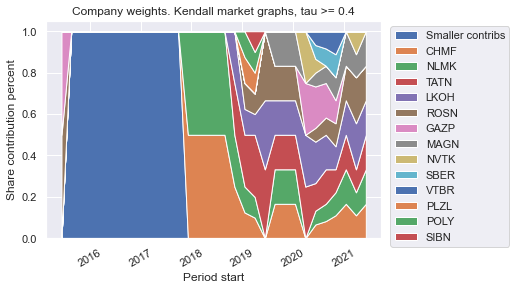

In [252]:
cdf = plot_area_chart(data, "kendall_0.40", 0.03)
plt.title("Company weights. Kendall market graphs, tau >= 0.4")

In [145]:
cdf_show = pd.Series(cdf.values[:, -15], cdf.index, name="Contribution percentage")
cdf_show.loc[cdf_show > 0]

Smaller contribs    0.1714
ROSN                0.1143
SBER                0.1143
TATN                0.0857
NVTK                0.1143
SIBN                0.1143
VTBR                0.1143
ALRS                0.1143
MAGN                0.0571
Name: Contribution percentage, dtype: float64

In [164]:
pd.set_option('display.max_columns', 32)

In [165]:
mc_sizes_cols = []
for method, threshold in thresholds_range:
    mc_sizes_cols.append(f"{method}_{threshold:.2f}")

mc_sizes = []
for period_data in data:
    mc_sizes.append([])
    for method, threshold in thresholds_range:
        mc_sizes[-1].append(period_data[1][f"{method}_{threshold:.2f}"]["max_clique_size"])
mc_sizes_df = pd.DataFrame(mc_sizes,
                           columns=mc_sizes_cols,
                           index=np.arange(1, len(periods) + 1))
mc_sizes_df.loc[:,:"pearson_0.90"].T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
pearson_0.00,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
pearson_0.10,17,18,18,18,17,21,20,22,23,22,19,17,19,19,19,30,34,35,37,37,38,40,41,37,40,60,58,61,65,64,63,63
pearson_0.20,10,10,10,9,9,9,9,10,11,10,9,8,8,8,8,15,19,18,21,21,22,21,22,21,25,47,45,46,53,53,52,51
pearson_0.30,8,7,7,6,4,6,6,6,6,5,5,4,3,3,3,6,7,7,8,9,10,10,10,10,11,36,33,33,37,38,38,36
pearson_0.40,4,4,4,4,4,4,4,4,3,3,3,2,3,3,3,4,4,4,5,5,6,7,7,7,7,21,20,20,23,24,26,27
pearson_0.50,3,3,3,2,2,3,3,3,3,2,2,2,2,2,2,3,4,4,4,4,4,4,4,4,5,12,11,10,12,12,12,13
pearson_0.60,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,3,3,3,3,3,4,4,6,6,5,6,6,6,7
pearson_0.70,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,4
pearson_0.80,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2
pearson_0.90,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Text(0.5, 1.0, 'Max clique sizes w/ Pearson correlation')

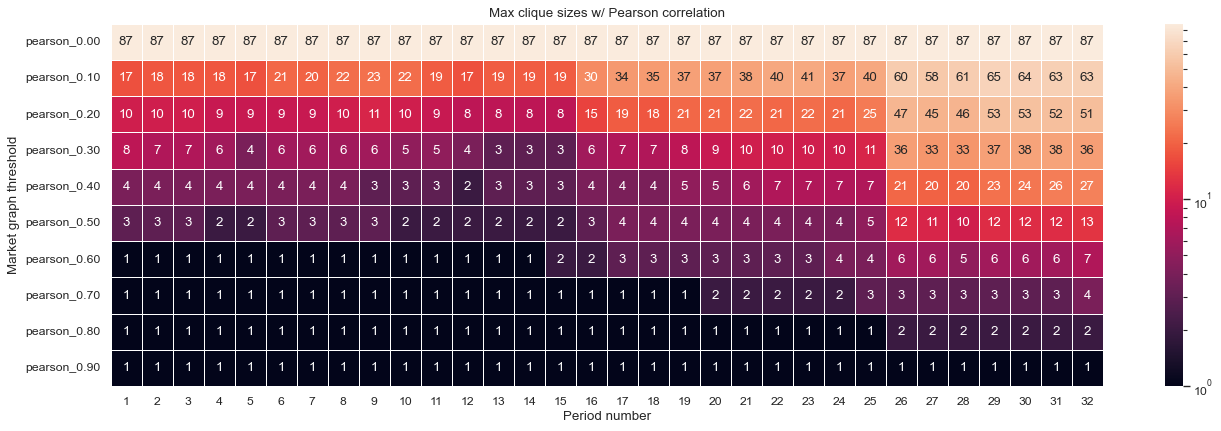

In [190]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_sizes_df.loc[:,:"pearson_0.90"].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Max clique sizes w/ Pearson correlation")

Text(0.5, 1.0, 'Max clique sizes w/ Kendall correlation')

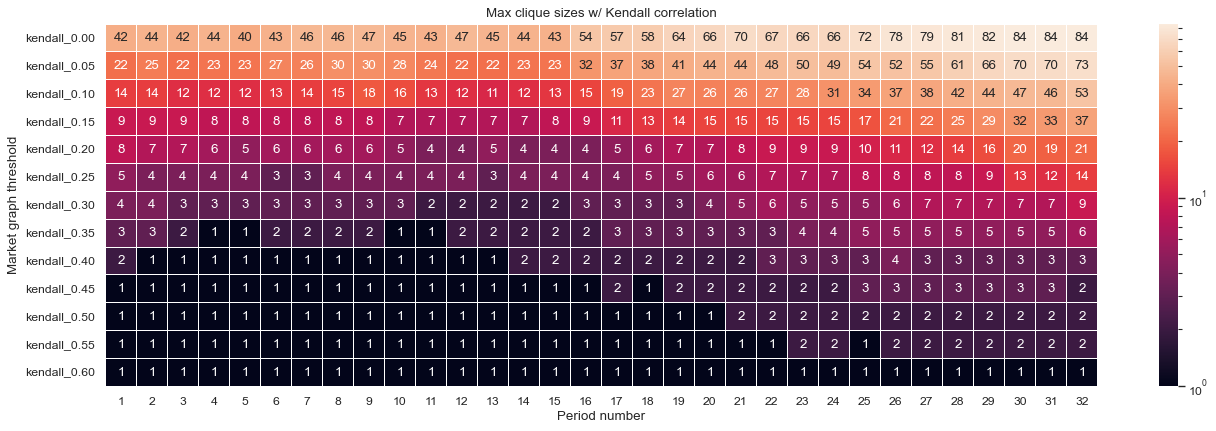

In [189]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_sizes_df.loc[:,"kendall_0.00":].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Max clique sizes w/ Kendall correlation")

In [207]:
mc_counts = []
for period_data in data:
    mc_counts.append([])
    for method, threshold in thresholds_range:
        mc_counts[-1].append(period_data[1][f"{method}_{threshold:.2f}"]["max_cliques_number"])
mc_counts_df = pd.DataFrame(mc_counts,
                            columns=mc_sizes_cols,
                            index=np.arange(1, len(periods) + 1))
mc_counts_df[mc_counts_df > 99] = 99
mc_counts_df.loc[:,"kendall_0.00":].T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
kendall_0.00,16,3,4,6,40,77,27,60,6,12,60,4,99,30,7,2,18,99,5,4,8,40,48,99,12,4,32,8,6,4,2,2
kendall_0.05,46,1,20,8,20,6,99,8,2,2,16,65,87,12,1,8,36,18,10,4,80,8,20,5,1,14,36,2,8,36,56,12
kendall_0.10,3,1,4,3,1,12,3,2,1,6,3,2,2,1,1,14,6,6,1,12,8,9,4,1,35,3,8,4,40,53,99,64
kendall_0.15,3,1,1,3,1,2,1,2,5,13,1,3,2,3,1,1,12,1,2,1,2,1,3,25,14,30,16,7,2,10,5,3
kendall_0.20,1,2,2,3,3,1,1,1,3,3,3,2,1,2,3,3,2,2,9,9,10,2,2,2,2,17,14,12,8,8,25,10
kendall_0.25,1,4,1,1,1,5,5,1,2,2,1,1,3,1,1,1,2,1,1,1,4,2,1,3,1,1,2,3,7,4,7,3
kendall_0.30,1,1,3,2,1,2,1,1,1,1,4,3,3,4,4,2,2,2,3,1,1,1,3,2,3,1,1,1,1,2,7,4
kendall_0.35,1,1,3,87,87,1,1,1,1,87,87,1,1,1,1,1,1,1,1,1,3,4,1,1,2,1,1,1,2,2,2,2
kendall_0.40,1,87,87,87,87,87,87,87,87,87,87,87,87,1,1,1,1,1,2,4,5,1,2,2,2,1,5,4,3,2,3,2
kendall_0.45,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,1,87,1,1,1,2,3,3,1,1,1,1,1,1,1,4


Text(0.5, 1.0, 'Count of maximum cliques w/ Pearson correlation')

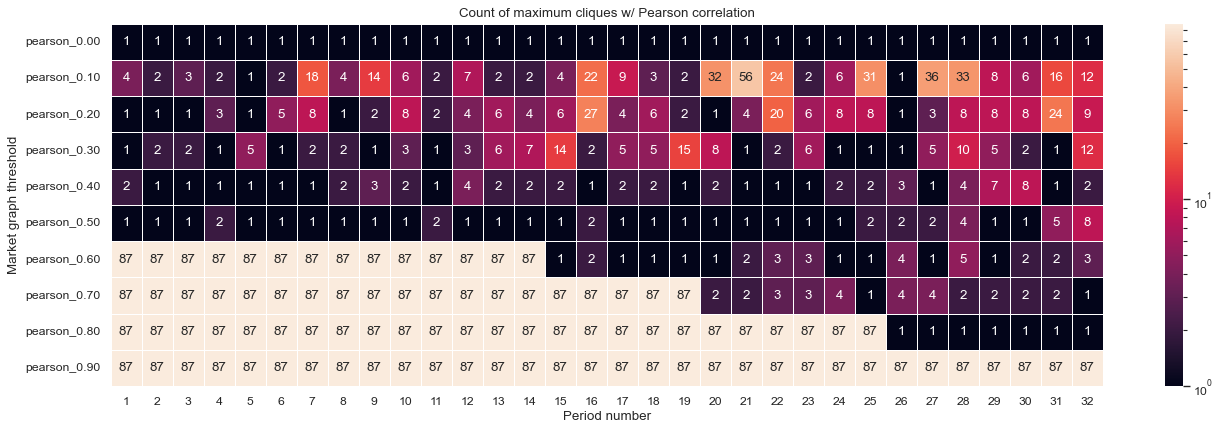

In [208]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_counts_df.loc[:,:"pearson_0.90"].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Count of maximum cliques w/ Pearson correlation")

Text(0.5, 1.0, 'Count of maximum cliques w/ Kendall correlation')

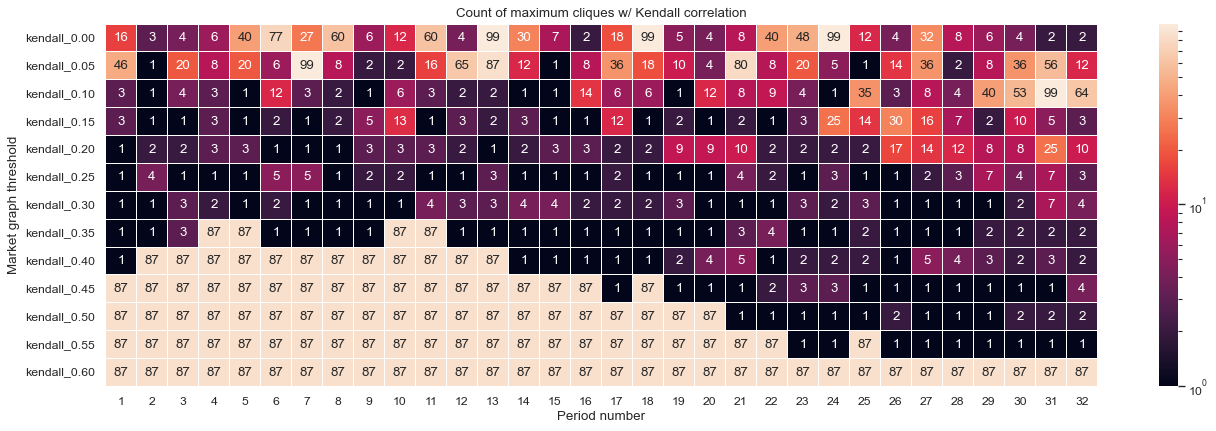

In [209]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_counts_df.loc[:,"kendall_0.00":].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Count of maximum cliques w/ Kendall correlation")

In [214]:
mc_unions = []
for period_data in data:
    mc_unions.append([])
    for method, threshold in thresholds_range:
        mc_unions[-1].append(len(period_data[1][f"{method}_{threshold:.2f}"]["shares_appearance_perc"]))
mc_unions_df = pd.DataFrame(mc_unions,
                            columns=mc_sizes_cols,
                            index=np.arange(1, len(periods) + 1))
mc_unions_df.loc[:,"kendall_0.00":].T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
kendall_0.00,46,46,44,47,47,55,54,55,50,49,51,50,56,50,47,55,62,70,67,68,73,74,72,75,76,80,84,84,85,86,85,85
kendall_0.05,34,25,28,27,30,30,37,34,31,29,30,32,36,30,23,35,43,43,45,46,57,51,56,52,54,58,61,62,69,76,78,77
kendall_0.10,16,14,16,14,12,18,16,16,18,19,15,13,12,12,13,24,22,26,27,30,29,31,30,31,41,39,42,44,51,56,55,60
kendall_0.15,11,9,9,10,8,9,8,9,13,16,7,9,8,9,8,9,15,13,15,15,18,15,17,24,24,28,26,30,30,36,37,39
kendall_0.20,8,8,8,8,7,6,6,6,8,7,6,5,5,5,8,8,6,7,13,13,14,10,10,10,12,21,21,20,21,25,26,29
kendall_0.25,5,7,4,4,4,9,11,4,5,5,4,4,7,4,4,4,5,5,5,6,9,8,7,9,8,8,9,10,13,16,17,17
kendall_0.30,4,4,5,4,3,4,3,3,3,3,6,5,5,7,7,6,6,6,5,4,5,6,7,6,7,6,7,7,7,8,11,11
kendall_0.35,3,3,4,87,87,2,2,2,2,87,87,2,2,2,2,2,3,3,3,3,7,8,4,4,6,5,5,5,6,6,6,7
kendall_0.40,2,87,87,87,87,87,87,87,87,87,87,87,87,2,2,2,2,2,4,7,8,3,6,6,6,4,10,9,9,6,7,6
kendall_0.45,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,2,87,2,2,2,4,6,6,3,3,3,3,3,3,3,7


Text(0.5, 1.0, 'Sizes of unions of maximum cliques w/ Pearson correlation')

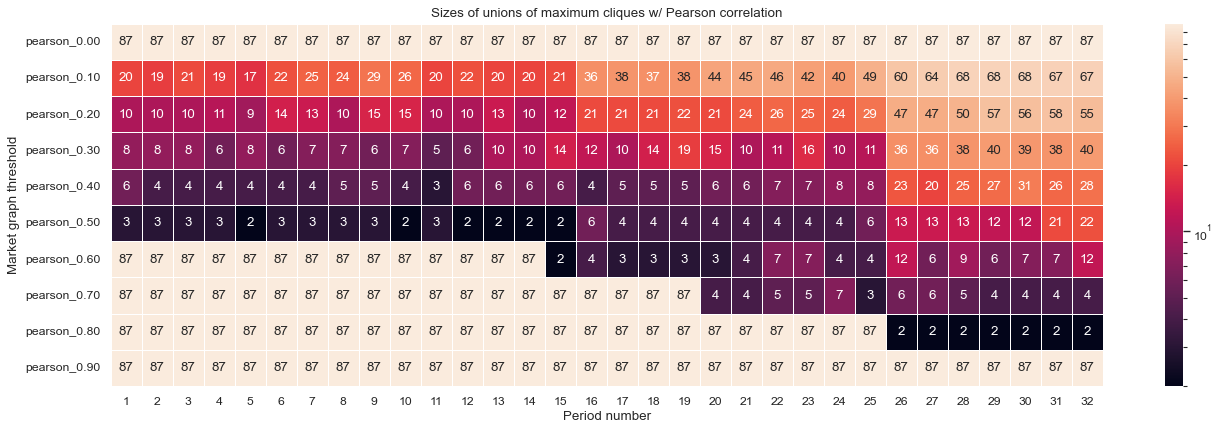

In [215]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_unions_df.loc[:,:"pearson_0.90"].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Sizes of unions of maximum cliques w/ Pearson correlation")

Text(0.5, 1.0, 'Sizes of unions of maximum cliques w/ Kendall correlation')

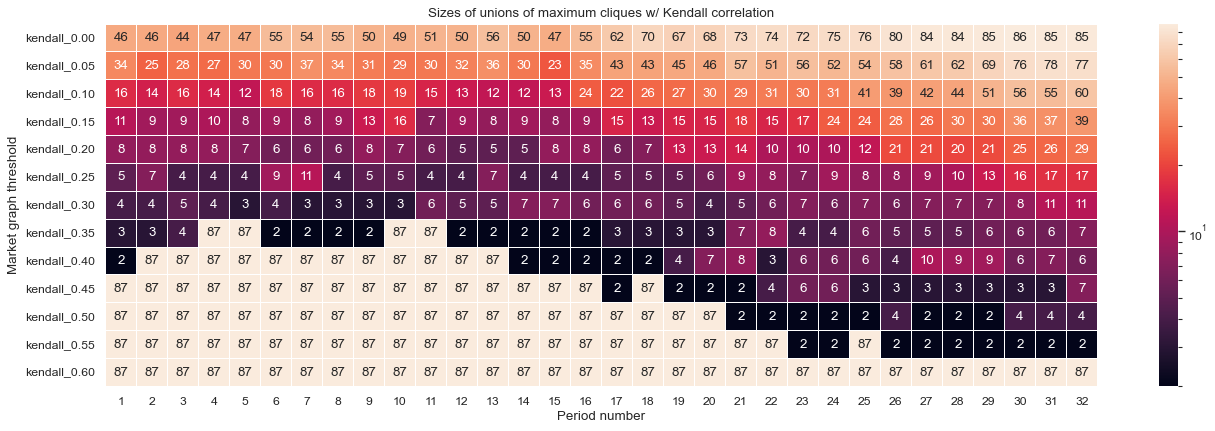

In [216]:
plt.figure(figsize=(20, 6), dpi=80)
sns.heatmap(mc_unions_df.loc[:,"kendall_0.00":].T, annot=True, linewidth=.5, norm=LogNorm())
plt.xlabel("Period number")
plt.ylabel("Market graph threshold")
plt.title("Sizes of unions of maximum cliques w/ Kendall correlation")

In [48]:
nx.draw(G.subgraph(stock_appearance_perc.keys()), with_labels=True)

NameError: name 'stock_appearance_perc' is not defined

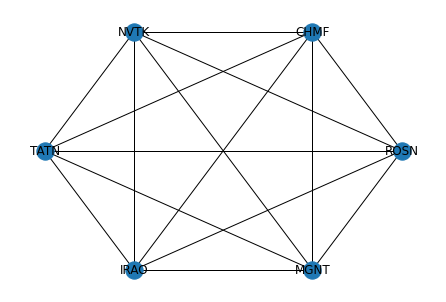

In [62]:
nx.draw_circular(G.subgraph(nx.approximation.max_clique(G)), with_labels=True)

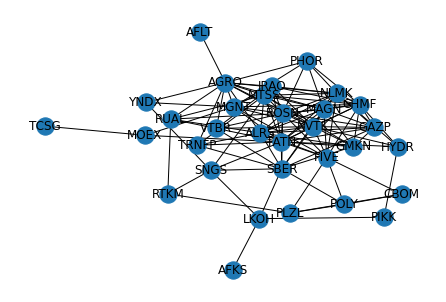

In [60]:
for i, component in enumerate(nx.connected_components(G)):
    nx.draw_kamada_kawai(G.subgraph(component), with_labels=True)
    plt.pause(0.05)
    if i == 10:
        break